# Introduction

In this tutorial, we demonstrate how to use PHATE (Potential of Heat-diffusion for Affinity-based Transition Embedding) to analyze a 31,000 cell 27-day time course of embryoid body (EB) differentiation. We review the following steps:

[1. Loading 10X data](#loading)  
[2. Preprocessing: Filtering, Normalizing, and Transforming](#preprocessing)  
[3. Embedding Data Using PHATE](#embedding)  


### Time course of human embryoid body differentation

Low passage H1 hESCs were maintained on Matrigel-coated dishes in DMEM/F12-N2B27 media supplemented with FGF2. For EB formation, cells were treated with Dispase, dissociated into small clumps and plated in non-adherent plates in media supplemented with 20% FBS,
45
which was prescreened for EB differentiation. Samples were collected during 3-day intervals during a 27 day-long differentiation timecourse. An undifferentiated hESC sample was also included (Figure S7D). Induction of key germ layer markers in these EB cultures was validated by qPCR (data not shown). For single cell analyses, EB cultures were dissociated, FACS sorted to remove doublets and dead cells and processed on a 10x genomics instrument to generate cDNA libraries, which were then sequenced. Small scale sequencing determined that we have successfully collected data on approximately 31,000 cells equally distributed throughout the timecourse.


<a id='loading'></a>
## 1. Loading 10X data

### Downloading Data from Mendeley Datasets

The EB dataset is publically available at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. First, download the zip archive containing data from all five time points. Here we'll assume the data is available at `/home/user/data/scRNAseq/`.


Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Here's the directory structure:
```
scRNAseq
├── T0_1A
│   ├── barcodes.tsv
│   ├── genes.tsv
│   └── matrix.mtx
├── T2_3B
│   ├── barcodes.tsv
│   ├── genes.tsv
│   └── matrix.mtx
├── T4_5C
│   ├── barcodes.tsv
│   ├── genes.tsv
│   └── matrix.mtx
├── T6_7D
│   ├── barcodes.tsv
│   ├── genes.tsv
│   └── matrix.mtx
└── T8_9E
    ├── barcodes.tsv
    ├── genes.tsv
    └── matrix.mtx
```

### Using PHATE.io to import data into Pandas DataFrames


The PHATE library has a toolkit for loading 10X data called `phate.io`. The function `load_10X` will automatically load these datasets into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).


Let's load the data and create a single datamatrix that we can use for preprocessing, visualization, and analysis.

#### 1. Standard imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import numpy as np
import phate

from sklearn.preprocessing import normalize

#### 2. Use `phate.io.load_10X` to import all three matrices into a DataFrame for each sample (this may take a few minutes and use several GB of memory)

Note: By default, `phate.io.load_10X` loads scRNA-seq data using the Pandas SparseDataFrame [(**see Pandas docs**)](https://pandas.pydata.org/pandas-docs/stable/sparse.html). This is so PHATE runs politely on laptops. However, this will be slower than loading on a dense matrix. To load a dense matrix, pass the `sparse=True` argument to `load_10X`. Here we're using dense matrices for the speed benefits.

In [2]:
T1 = phate.io.load_10X('/home/user/scRNAseq/T0_1A/', sparse=False)
T2 = phate.io.load_10X('/home/user/scRNAseq/T2_3B/', sparse=False)
T3 = phate.io.load_10X('/home/user/scRNAseq/T4_5C/', sparse=False)
T4 = phate.io.load_10X('/home/user/scRNAseq/T6_7D/', sparse=False)
T5 = phate.io.load_10X('/home/user/scRNAseq/T8_9E/', sparse=False)

Imported data matrix with 4649 cells and 33694 genes.
Imported data matrix with 7377 cells and 33694 genes.
Imported data matrix with 6245 cells and 33694 genes.
Imported data matrix with 6563 cells and 33694 genes.
Imported data matrix with 6327 cells and 33694 genes.


#### 3. Create a vector representing the time point of each sample

In [3]:
sample_labels = np.hstack([(np.ones(T1.shape[0],dtype=int)),
                           (np.ones(T2.shape[0],dtype=int) * 2),
                           (np.ones(T3.shape[0],dtype=int) * 3),
                           (np.ones(T4.shape[0],dtype=int) * 4),
                           (np.ones(T5.shape[0],dtype=int) * 5)])

#### 4. Merge all datasets and remove temporary files to free memory

In [4]:
EBT_counts = pd.concat([T1, T2, T3, T4, T5])

EBT_counts.index = pd.Index(EBT_counts.index.values + '#' + sample_labels.astype(int).astype(str)) # Adding sample label to index because of some overlap in cell barcodes

del T1, T2, T3, T4, T5 # removes objects from memory

<a id='preprocessing'></a>
## 2. Preprocessing: Filtering, Normalizing, and Transforming

### Filtering

We filter the data by: 
1. Removing dead cells  
2. Filtering by library size  
3. Removing genes that are expressed in relatively few cells.

#### 2.1 Dead cell removal

Dead cells are likely to have a higher mitochondrial RNA expression level than live cells. Therefore, we remove suspected dead cells by eliminating cells that have the highest mitochondrial RNA expression levels on average.  

First let's look at the distribution of mitochontrial genes.

In [5]:
mito_genes = [gene_symbol.startswith('MT-') for gene_symbol in EBT_counts.columns] # Get all mitochondrial genes. There are 14, FYI.

lib_size =  EBT_counts.sum(axis=1)

mito_expression = np.mean(EBT_counts.loc[:,mito_genes].values / lib_size.values[:,None], axis=1)

top_pct = np.percentile(mito_expression, 90) # top 10 percentile

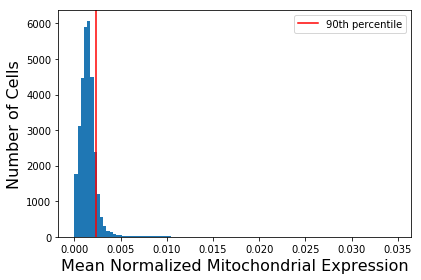

In [6]:
h = plt.hist(mito_expression , bins=100)
plt.axvline(top_pct, c='r', label='90th percentile')
plt.xlabel('Mean Normalized Mitochondrial Expression', fontsize=16)
plt.ylabel('Number of Cells', fontsize=16)
plt.legend()
plt.tight_layout()

Here we see that above the top 90th percentile, there is a steep increase in expression of mitochondrial RNAs. We'll remove these cells from further analysis.

In [7]:
EBT_counts    = EBT_counts.iloc[mito_expression < top_pct]
sample_labels = sample_labels[mito_expression < top_pct]
lib_size      = lib_size[mito_expression < top_pct]

** Library size filtering **

We filter out cells that have either very large or very small library sizes. For this data set, library size correlates somewhat with sample and so we filter on a per-sample basis. In this case, we eliminate the top and bottom 20% of cells for each sample. Similar results are obtained with less conservative filtering.

In [29]:
cells_to_drop = np.zeros(EBT_counts.shape[0],dtype=bool)

for i in [1,2,3,4,5]:
    cells = sample_labels == i
    
    min_ls = np.percentile(lib_size[cells], 20)
    max_ls = np.percentile(lib_size[cells], 80)
    drop_mask = (min_ls >= lib_size) | (lib_size >= max_ls)
    
    cells_to_drop[cells & drop_mask] = True

In [31]:
EBT_counts    = EBT_counts.iloc[~cells_to_drop]
sample_labels = sample_labels[~cells_to_drop]
lib_size      = lib_size[~cells_to_drop]

#### Remove rare genes

We eliminate genes that are expressed in 10 cells or fewer.

In [ ]:
genes_keep=sum(data)>10
data=data(:,genes_keep)
genes=genes(genes_keep)

In [38]:
genes_keep = np.sum(EBT_counts, axis=0) > 10
EBT_counts = EBT_counts.loc[:,genes_keep]

### Normalization

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In python this is performed using the preprocessing method `library_size_normalize()`.

In [39]:
EBT_counts = phate.preprocessing.library_size_normalize(EBT_counts)

### Transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [41]:
EBT_counts = np.sqrt(EBT_counts)

<a id='embedding'></a>
## 3. Embedding Data Using PHATE

### 3.1 Instantiating the PHATE estimator

The API of PHATE models that of SciKit-Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/en/latest/).



Here's the simplest way to apply PHATE:

In [48]:
phate_operator = phate.PHATE(n_components=2, a=10, k=12, alpha_decay=True, n_jobs=-2)

Y_2Dmmds = phate_operator.fit_transform(EBT_counts)

Building kNN graph and diffusion operator...
Built graph and diffusion operator in 73.82 seconds.
Automatically selected t = 19
Calculating diffusion potential...
Calculated diffusion potential in 0.31 seconds.
Embedding data using metric MDS...
Embedded data in 10.42 seconds.
Finished PHATE embedding in 103.78 seconds.



And then we plot using matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

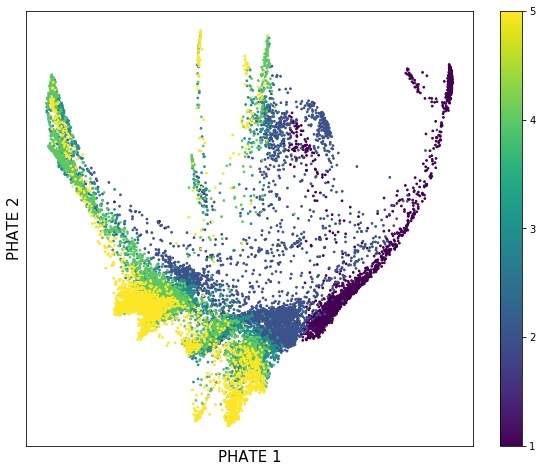

In [49]:
f, ax = plt.subplots(1)
f.set_size_inches(10,8)

sc = ax.scatter(Y_2Dmmds[:,0], Y_2Dmmds[:,1], c=sample_labels, s=3)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('PHATE 1', fontsize=15)
ax.set_ylabel('PHATE 2', fontsize=15)

ax.set_title('')

f.colorbar(sc, ticks=[1,2,3,4,5])